# MNIST, Computer Vision from Scratch

|  | Monday 4-5:30pm | Friday  4-5:30pm |
|:------:|:-------------------------------------------:|:--------------------------------------------------------------------------:|
| **Week 1** | Introduction | Introduction |
| **Week 2** | Custom computer vision tasks | State of the art in Computer Vision |
| **Week 3** | Introduction to Tabular modeling and pandas | Pandas workshop and feature engineering |
| **Week 4** | Tabular and Image Regression | Feature importance and advanced feature  engineering |
| **Week 5** | Natural Language Processing | State of the art in NLP |
| **Week 6** | Segmentation and Kaggle | Audio |
| **Week 7** | **Computer vision from scratch** | NLP from scratch |
| **Week 8** | Callbacks | Optimizers |
| **Week 9** | Generative Adversarial Networks | Research time / presentations |
| **Week 10** | Putting models into production | Putting models into production |

Arguably the most famous example for machine Learning. Given hand-written numbers, identify them/classify them. Here we will build our own model to do this as well as use our ImageList function

In [0]:
from fastai import *
from fastai.vision import *

# Data

When we make a DataBunch, here is what is really happening:

List->Split->Label->Apply Transforms->Convert to batches

In [0]:
path = untar_data(URLs.MNIST)

In [0]:
path.ls()

[PosixPath('/root/.fastai/data/mnist_png/testing'),
 PosixPath('/root/.fastai/data/mnist_png/training')]

In [0]:
il = ImageList.from_folder(path, convert_mode='L')
# L means we have a single-channel image (black and white)
# Could be RGB

In [0]:
il.items[0]

PosixPath('/root/.fastai/data/mnist_png/testing/8/6850.png')

In [0]:
defaults.cmap='binary' # Black and white

In [0]:
il

ImageList (70000 items)
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
Path: /root/.fastai/data/mnist_png

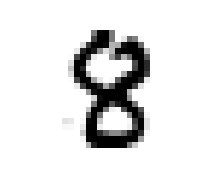

In [0]:
il[0].show()

In [0]:
sd = il.split_by_folder(train='training', valid='testing')

In [0]:
sd

ItemLists;

Train: ImageList (60000 items)
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
Path: /root/.fastai/data/mnist_png;

Valid: ImageList (10000 items)
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
Path: /root/.fastai/data/mnist_png;

Test: None

In [0]:
(path/'training').ls()

[PosixPath('/root/.fastai/data/mnist_png/training/8'),
 PosixPath('/root/.fastai/data/mnist_png/training/9'),
 PosixPath('/root/.fastai/data/mnist_png/training/1'),
 PosixPath('/root/.fastai/data/mnist_png/training/0'),
 PosixPath('/root/.fastai/data/mnist_png/training/6'),
 PosixPath('/root/.fastai/data/mnist_png/training/4'),
 PosixPath('/root/.fastai/data/mnist_png/training/7'),
 PosixPath('/root/.fastai/data/mnist_png/training/2'),
 PosixPath('/root/.fastai/data/mnist_png/training/5'),
 PosixPath('/root/.fastai/data/mnist_png/training/3')]

In [0]:
ll = sd.label_from_folder()

In [0]:
ll

LabelLists;

Train: LabelList (60000 items)
x: ImageList
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
y: CategoryList
8,8,8,8,8
Path: /root/.fastai/data/mnist_png;

Valid: LabelList (10000 items)
x: ImageList
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
y: CategoryList
8,8,8,8,8
Path: /root/.fastai/data/mnist_png;

Test: None

In [0]:
x, y = ll.train[0]

8 torch.Size([1, 28, 28])


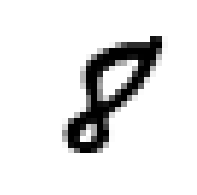

In [0]:
x.show()
print(y, x.shape)

In [0]:
tfms = ([*rand_pad(padding=3, size=28, mode='zeros')], [])

In [0]:
ll = ll.transform(tfms)

In [0]:
bs=128

In [0]:
data = ll.databunch(bs=bs).normalize()
# We do not use imagenet as we are training from scratch

In [0]:
x,y = data.train_ds[0]

8


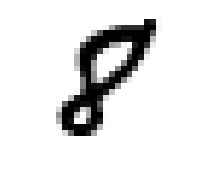

In [0]:
x.show()
print(y)

We can plot our data to see our transforms

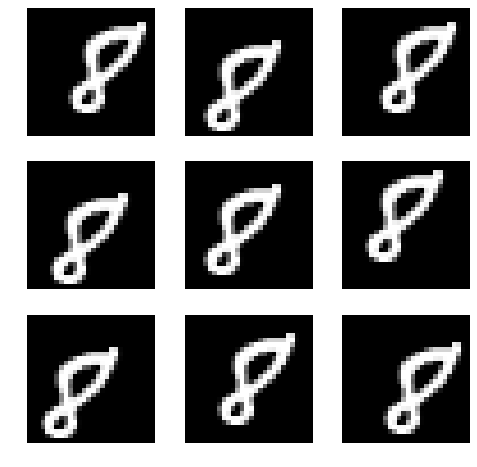

In [0]:
def _plot(i,j,ax): data.train_ds[0][0].show(ax, cmap='gray')
plot_multi(_plot, 3, 3, figsize=(8,8))

In [0]:
xb,yb = data.one_batch()
xb.shape,yb.shape

(torch.Size([128, 1, 28, 28]), torch.Size([128]))

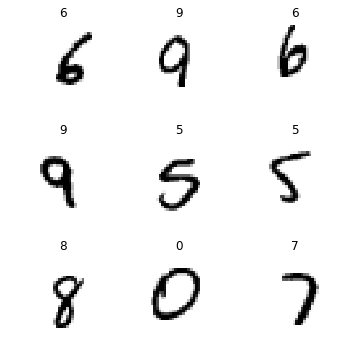

In [0]:
data.show_batch(rows=3, figsize=(5,5))

# Basic CNN with BatchNormalization

In [0]:
def conv(ni, nf): return nn.Conv2d(ni, nf, kernel_size=3, stride=2, padding=1)
# ni = input channels
# nf = output channels
# stride controls stride for cross-correlation
# padding: controls zero-paddings

https://pytorch.org/docs/stable/nn.html

In [0]:
net = nn.Sequential(
    conv(1,8), #14 Grid
    nn.BatchNorm2d(8),
    nn.ReLU(),
    conv(8,16), #7 Grid
    nn.BatchNorm2d(16),
    nn.ReLU(),
    conv(16,32), #4 Grid
    nn.BatchNorm2d(32),
    nn.ReLU(),
    conv(32,16), #2 Grid
    nn.BatchNorm2d(16),
    nn.ReLU(),
    conv(16,10), #1 Grid
    nn.BatchNorm2d(10),
    Flatten() #remove 1x1 grid
)

In [0]:
learn = Learner(data, net, loss_func=nn.CrossEntropyLoss(), metrics=accuracy)

In [0]:
print(learn.summary())

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [8, 14, 14]          80         True      
______________________________________________________________________
BatchNorm2d          [8, 14, 14]          16         True      
______________________________________________________________________
ReLU                 [8, 14, 14]          0          False     
______________________________________________________________________
Conv2d               [16, 7, 7]           1,168      True      
______________________________________________________________________
BatchNorm2d          [16, 7, 7]           32         True      
______________________________________________________________________
ReLU                 [16, 7, 7]           0          False     
______________________________________________________________________
Conv2d               [32, 4, 4]           4,640      True      
___________________________________________________

In [0]:
xb = xb.cuda()

In [0]:
net(xb).shape

torch.Size([128, 10])

In [0]:
net(xb)

tensor([[ 0.0082, -0.0021,  0.0105,  ..., -0.0465, -0.0164,  0.0327],
        [ 0.0083, -0.0020,  0.0104,  ..., -0.0465, -0.0164,  0.0328],
        [ 0.0082, -0.0020,  0.0104,  ..., -0.0465, -0.0164,  0.0327],
        ...,
        [ 0.0082, -0.0021,  0.0105,  ..., -0.0465, -0.0164,  0.0328],
        [ 0.0082, -0.0020,  0.0105,  ..., -0.0465, -0.0164,  0.0327],
        [ 0.0082, -0.0021,  0.0104,  ..., -0.0466, -0.0164,  0.0327]],
       device='cuda:0', grad_fn=<ViewBackward>)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


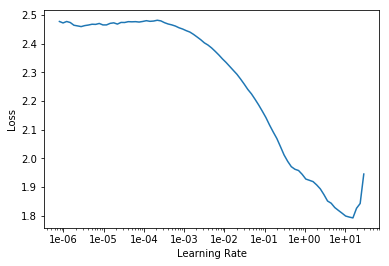

In [0]:
learn.lr_find(end_lr=100) # end number of batches to do
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(3, max_lr=1e-1)

epoch,train_loss,valid_loss,accuracy,time
0,0.221940,0.240553,0.924600,00:29
1,0.128697,0.079913,0.974600,00:29
2,0.065182,0.039652,0.988200,00:29


# Let's do some code refactoring

In [0]:
def conv2(ni, nf): return conv_layer(ni, nf, stride=2)

In [0]:
conv_layer??

In [0]:
conv2(1, 1)

Sequential(
  (0): Conv2d(1, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (1): ReLU(inplace)
  (2): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [0]:
net = nn.Sequential(
    conv2(1,8),    # 14
    conv2(8,16),   # 7
    conv2(16,32),  # 4
    conv2(32, 16), # 2
    conv2(16, 10), # 1
    Flatten()      # remove (1,1) grid
  )

In [0]:
net

Sequential(
  (0): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): ReLU(inplace)
    (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): ReLU(inplace)
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): ReLU(inplace)
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (3): Sequential(
    (0): Conv2d(32, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): ReLU(inplace)
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (4): Sequential(
    (0): Conv2d(16, 10, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False

In [0]:
learn = Learner(data, net, loss_func=nn.CrossEntropyLoss(), metrics=accuracy)

In [0]:
learn.fit_one_cycle(10, max_lr=1e-1)

epoch,train_loss,valid_loss,accuracy,time
0,0.258700,0.138030,0.957500,00:29
1,0.206755,0.224354,0.931900,00:29
2,0.174355,0.133010,0.954700,00:29
3,0.136757,0.208368,0.940500,00:28
4,0.117587,0.067598,0.977900,00:28
5,0.102790,0.090867,0.971500,00:29
6,0.077361,0.047422,0.984200,00:29
7,0.059364,0.037560,0.988000,00:28
8,0.050628,0.027564,0.991400,00:29
9,0.049077,0.026511,0.991300,00:28


# Let's build something more ResNet-Like

In [0]:
class Resblock(nn.Module):
  def __init__(self, nf):
    super().__init__()
    self.conv1 = conv_layer(nf, nf)
    self.conv2 = conv_layer(nf, nf)
    
  def forward(self, x): return x + conv2(self.conv1(x))

In [0]:
help(res_block)

Help on function res_block in module fastai.layers:

res_block(nf, dense:bool=False, norm_type:Union[fastai.layers.NormType, NoneType]=<NormType.Batch: 1>, bottle:bool=False, **conv_kwargs)
    Resnet block of `nf` features. `conv_kwargs` are passed to `conv_layer`.



In [0]:
net = nn.Sequential(
    conv2(1, 8),
    res_block(8),
    conv2(8, 16),
    res_block(16),
    conv2(16, 32),
    res_block(32),
    conv2(32, 16),
    res_block(16),
    conv2(16, 10),
    Flatten()
)

In [0]:
net

Sequential(
  (0): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): ReLU(inplace)
    (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): SequentialEx(
    (layers): ModuleList(
      (0): Sequential(
        (0): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): ReLU(inplace)
        (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): Sequential(
        (0): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): ReLU(inplace)
        (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (2): MergeLayer()
    )
  )
  (2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): ReLU(inplace)
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats

In [0]:
def conv_and_res(ni, nf): return nn.Sequential(conv2(ni, nf), res_block(nf))

In [0]:
net = nn.Sequential(
    conv_and_res(1, 8),
    conv_and_res(8, 16),
    conv_and_res(16, 32),
    conv_and_res(32, 16),
    conv2(16, 10),
    Flatten()
)

In [0]:
net

Sequential(
  (0): Sequential(
    (0): Sequential(
      (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): ReLU(inplace)
      (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): SequentialEx(
      (layers): ModuleList(
        (0): Sequential(
          (0): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): ReLU(inplace)
          (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): Sequential(
          (0): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): ReLU(inplace)
          (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (2): MergeLayer()
      )
    )
  )
  (1): Sequential(
    (0): Sequential(
      (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): ReLU(inp

In [0]:
learn = Learner(data, net, loss_func=nn.CrossEntropyLoss(), metrics=accuracy)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


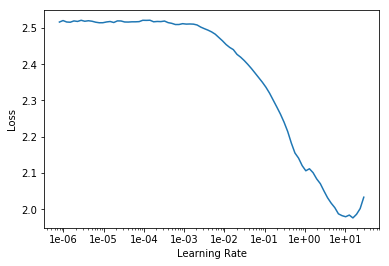

In [0]:
learn.lr_find(end_lr=100)
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(12, max_lr=0.05)

epoch,train_loss,valid_loss,accuracy,time
0,0.247349,0.227389,0.938000,00:31
1,0.132665,0.116402,0.963300,00:31
2,0.112198,0.248668,0.929800,00:31
3,0.091233,0.083336,0.974100,00:31
4,0.072902,0.092034,0.974100,00:32
5,0.064188,0.037468,0.988700,00:31
6,0.049651,0.043785,0.986800,00:31
7,0.041239,0.038790,0.988300,00:31
8,0.032550,0.025832,0.991700,00:31
9,0.026756,0.018742,0.994000,00:31


In [0]:
print(learn.summary())

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [8, 14, 14]          72         True      
______________________________________________________________________
ReLU                 [8, 14, 14]          0          False     
______________________________________________________________________
BatchNorm2d          [8, 14, 14]          16         True      
______________________________________________________________________
Conv2d               [8, 14, 14]          576        True      
______________________________________________________________________
ReLU                 [8, 14, 14]          0          False     
______________________________________________________________________
BatchNorm2d          [8, 14, 14]          16         True      
______________________________________________________________________
Conv2d               [8, 14, 14]          576        True      
___________________________________________________